## Energy-based GAN Implementation

Based on the paper: <i>Energy-based Generative Adversarial Networks</i>. I found that pretraining the discriminator(AE) was paramount for the GAN training to converge.

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Dense,Reshape,Dropout,BatchNormalization,Activation,UpSampling2D,Embedding
from tensorflow.keras.layers import BatchNormalization,Conv2D,LeakyReLU,Flatten,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import BinaryCrossentropy,MSE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
tf.keras.backend.set_floatx('float32')

import warnings
warnings.filterwarnings('ignore')

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train = x_train[y_train <= 3] # using numbers 0,1,2,3
y_train = y_train[y_train <= 3]
y_train = y_train.astype("int32")
y_train = np.expand_dims(y_train,axis=-1)
x_train = (x_train-127.5)/127.5 # scaling the images
x_train = np.expand_dims(x_train,axis=-1)
x_train = x_train[:24750]
y_train = y_train[:24750]
print(x_train.shape,y_train.shape)

(24750, 28, 28, 1) (24750, 1)


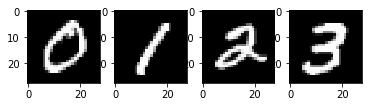

In [3]:
plt.subplot(1,4,1)
plt.imshow(np.squeeze(x_train[0]),cmap="gray")
plt.subplot(1,4,2)
plt.imshow(np.squeeze(x_train[1]),cmap="gray")
plt.subplot(1,4,3)
plt.imshow(np.squeeze(x_train[2]),cmap="gray")
plt.subplot(1,4,4)
plt.imshow(np.squeeze(x_train[4]),cmap="gray")
plt.show()

### Model implementation

In [4]:
def get_generator(noise_dim=100):
    """ EB generator implementation
    """
    z = Input(shape=(noise_dim))
    h = Dense(7*7*256)(z)
    h = Reshape((7,7,256))(h)
    
    h = UpSampling2D()(h)
    h = Conv2D(filters=128,kernel_size=4,strides=1,padding='same',activation=None)(h)
    h = BatchNormalization(momentum=0.8)(h)
    h = LeakyReLU(0.2)(h)
    h = UpSampling2D()(h)
    h = Conv2D(filters=64,kernel_size=4,strides=1,padding='same',activation=None)(h)
    h = BatchNormalization(momentum=0.8)(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(filters=1,kernel_size=3,strides=1,padding='same',activation=None)(h)
    h = Activation('tanh')(h)
    
    model = Model(inputs=z,outputs=h)
    return model

In [5]:
def get_discriminator():
    """ EB discriminator implementation
        -effectively an autoencoder
    """
    x = Input(shape=(28,28,1))
    
    e = Conv2D(filters=64,kernel_size=3,strides=2,padding='same',activation='relu',kernel_regularizer=None)(x)
    e = Conv2D(filters=128,kernel_size=3,strides=1,padding='same',activation='relu',kernel_regularizer=None)(e)
    
    d = UpSampling2D()(e)
    d = Conv2D(filters=64,kernel_size=4,strides=1,padding='same',activation='relu',kernel_regularizer=None)(d)
    d = Conv2D(filters=1,kernel_size=4,strides=1,padding='same',activation=None,kernel_regularizer=None)(d)
    d = Activation('tanh')(d)
    
    model = Model(inputs=x,outputs=d)
    return model

In [6]:
def discriminator_loss(gen,dec_gen,real,dec_real,margin=10):
    """ mse loss using margin to maximize reconstruction loss of generated images when compared to real images
    args:
        gen: generated image from generator
        dec_gen: output of decoder from AE when inputting generated image
        real: genuine MNIST image
        dec_real: output of decoder from AE when inputting real image
    """
    gen,dec_gen = Flatten()(gen),Flatten()(dec_gen)
    real,dec_real = Flatten()(real),Flatten()(dec_real)
    
    gen_mse = MSE(gen,dec_gen)
    real_mse = MSE(real,dec_real)
    loss = tf.reduce_mean(tf.maximum(real_mse+(margin-gen_mse),0.0))
    return loss

In [7]:
@tf.function
def train_discriminator(model,optimizer,gen,real,margin=10):
    """ training step for discriminator network
    """
    with tf.GradientTape() as tape:
        dec_gen = model(gen)
        dec_real = model(real)
        loss = discriminator_loss(gen,dec_gen,real,dec_real,margin=margin)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    return loss

In [8]:
def get_adversarial_model(generator,discriminator,noise_dim=100):
    """ adversarial model implementation - used to train generator
    """
    z = Input(shape=(noise_dim))
    gen = generator(z)
    dec_gen = discriminator(gen)
    
    model = Model(inputs=z,outputs=[dec_gen,gen])
    return model

In [9]:
def adversarial_loss(gen,dec_gen):
    """ mse loss - update generator to minimize reconstruction loss of generated images
    """
    gen,dec_gen = Flatten()(gen),Flatten()(dec_gen)
    loss = tf.reduce_mean(MSE(gen,dec_gen))
    return loss

In [10]:
@tf.function
def train_adversarial(model,optimizer,z):
    """ training step for adversarial network
    """
    with tf.GradientTape() as tape:
        dec_gen,gen = model(z)
        loss = adversarial_loss(gen,dec_gen)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    return loss

In [11]:
discriminator = get_discriminator()
generator = get_generator()
adversarial = get_adversarial_model(generator,discriminator)

In [12]:
def get_pretrain_discriminator(discriminator,optimizer):
    model = Sequential()
    model.add(discriminator)
    model.compile(loss="mse",optimizer=optimizer)
    return model

In [13]:
pretrain_discriminator = get_pretrain_discriminator(discriminator,optimizer=Adam(lr=0.001))

In [14]:
# training the AE discriminator first
num_epochs=1
batch_size=50
for epoch_i in range(num_epochs): # number of epochs
    all_d_losses = []
    
    for i in range(0,len(x_train),batch_size):
        x_subset = x_train[i:i+batch_size]
        
        # training the discriminator:
        z = np.random.normal(0.0,1.0,size=(batch_size,100))
        d_loss = pretrain_discriminator.train_on_batch(x_subset,x_subset)
        all_d_losses.append(float(d_loss))
    print("Epoch {}: {}".format(epoch_i+1,sum(all_d_losses)/len(all_d_losses)))

Epoch 1: 0.009896575435149399


### Model Training

The noise prior z~N(0,1)

In [17]:
disc_optimizer = Adam(lr=0.0002)
gen_optimizer = Adam(lr=0.0001)

num_epochs=50
batch_size=50

for epoch_i in range(num_epochs): # number of epochs
    all_a_losses = []
    all_d_losses = []
    print("Epoch {}:".format(epoch_i+1))
    
    for i in range(0,len(x_train),batch_size):
        x_subset = x_train[i:i+batch_size]
        
        # training the discriminator:
        z = np.random.normal(0.0,1.0,size=(batch_size,100))
        x_gen = generator(z)
        discriminator.trainable=True
        # splitting into two separate batches:
        d_loss = train_discriminator(discriminator,disc_optimizer,x_gen[:25],x_subset[:25])
        all_d_losses.append(float(d_loss))
        d_loss = train_discriminator(discriminator,disc_optimizer,x_gen[25:],x_subset[25:])
        all_d_losses.append(float(d_loss))
            
        # training the generator:
        z = np.random.normal(0.0,1.0,size=(batch_size,100))
        discriminator.trainable=False
        a_loss = train_adversarial(adversarial,gen_optimizer,z)
        all_a_losses.append(float(a_loss))
        
        if i%2000 == 0:
            plt.figure(figsize=(15,4))
            for i in range(10):
                this_noise = np.random.normal(0.0,1.0,size=(1,100))
                gen = generator(this_noise).numpy()
                gen.shape=(28,28)
                plt.subplot(1,10,i+1)
                plt.imshow(gen,cmap="gray")
            plt.show()
            
    print("gen. loss:{}; disc. loss:{}".format(sum(all_a_losses)/len(all_a_losses),sum(all_d_losses)/len(all_d_losses)))            
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")

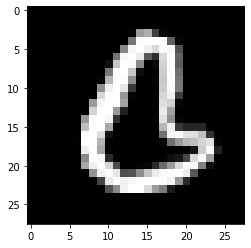

In [31]:
this_noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator(this_noise).numpy()
gen.shape=(28,28)
plt.imshow(gen,cmap="gray")
plt.show()

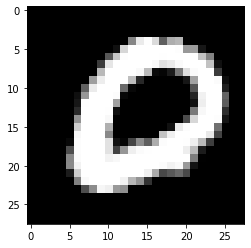

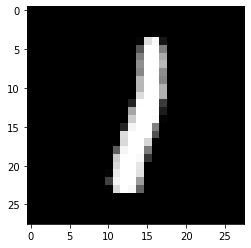

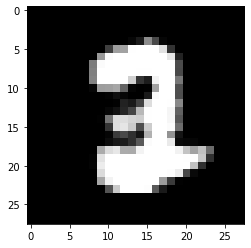

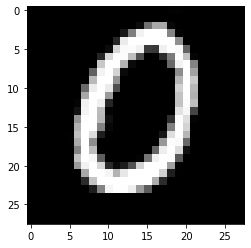

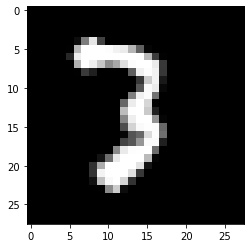

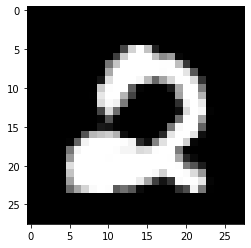

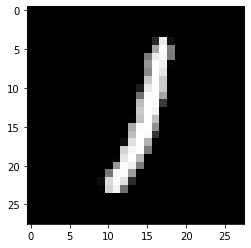